In [1]:
import os

os.chdir("..")

In [ ]:
from datasetsforecast.m3 import M3
from utilsforecast.plotting import plot_series
import pandas as pd
from models.NBeatsStackMoe import NBeatsStackMoe
from models.NBeatsMoeLags import NBeatsMoeLags
from neuralforecast import NeuralForecast
from utils import load_dataset, train_test_split
from models.callbacks.probs_collector import GateValuesCollectorCallback
from neuralforecast.losses.numpy import smape
from neuralforecast.models import NBEATS
from neuralforecast.tsdataset import TimeSeriesDataset
import matplotlib.pyplot as plt
from datasets.load_data.gluonts_dataset import GluontsDataset
from models.hyper import config
import numpy as np

# Load the M3 dataset
# m3 = M3.load(directory='C:\\Users\\ricar\\mixture_of_experts_time_series\\data\\m3\\', group='Monthly')[0]
m1, horizon, n_lags, freq_str, freq_int = GluontsDataset.load_everything("m1_monthly")

m1['y'] = m1['y'].astype(float)

# m4['ds'] = pd.to_datetime(m4['ds']).astype(int)

In [ ]:
horizon = horizon
input_size = n_lags

In [2]:
from neuralforecast.losses.numpy import smape
def calculate_smape(Y_test_df, Y_hat_df, forecast_col):
    """Calculate the sMAPE."""
    print(Y_test_df,Y_hat_df)

    y_true = Y_test_df['y'].values
    try:
        y_hat = Y_hat_df[forecast_col].values
    except Exception as exc:
        y_hat = Y_hat_df
   
    n_series = Y_test_df['unique_id'].nunique()
    try:
        y_true = y_true.reshape(n_series, -1)
        y_hat = y_hat.reshape(n_series, -1)
    except Exception as e:
        raise ValueError("Error reshaping arrays") from e


    return smape(y_true, y_hat)

c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-17 21:36:10,480	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-06-17 21:36:10,643	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [5]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from functools import partial
from utilsforecast.losses import mase, rmse, mse, mae
from modelradar.evaluate.radar import ModelRadar
from matplotlib.cm import get_cmap

# Enable pgf backend for LaTeX-friendly output
matplotlib.use("pgf")

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
})

# Centralized model style settings
model_styles = {
    'N-BEATS': {
        'color': '#d62728',  # Muted Blue
        'linestyle': '-'
    },
    'N-BEATS-MOE': {
        'color': '#ff7f0e',  # Orange
        'linestyle': '-'
    },
    'MoEBlock': {
        'color': '#2ca02c',  # Green
        'linestyle': '-'
    },
    'SeasonalNaive': {
        'color': '#1f77b4',  # Red
        'linestyle': '-'
    },
}



def get_aspect_forecast_samples(radar, err_df, y_test, y_hats, models_dict, n_samples=4):
    """
    Get unique sample IDs for different aspects and their corresponding forecasts.
    Ensures no repeated unique_ids across aspects.
    """
    aspect_samples = {}
    used_uids = set()

    def get_unique_uids(candidates, label):
        new_uids = [uid for uid in candidates if uid not in used_uids]
        selected = list(np.random.choice(new_uids, min(n_samples, len(new_uids)), replace=False))
        used_uids.update(selected)
        aspect_samples[label] = selected

    # Hard
    hard_uids = radar.uid_accuracy.get_hard_uids(err_df, return_df=True).index.tolist()
    get_unique_uids(hard_uids, 'Hard')

    # Anomalies
    if 'anomaly_status' in y_test.columns:
        anomaly_uids = y_test[y_test['anomaly_status'] == 'Anomalies']['unique_id'].unique()
        get_unique_uids(anomaly_uids, 'Anomalies')

    # Seasonal
    if 'seas_str' in y_test.columns:
        seasonal_uids = y_test[y_test['seas_str'] == 'Seasonal']['unique_id'].unique()
        get_unique_uids(seasonal_uids, 'Seasonal')

    # Stationary
    if 'trend_str' in y_test.columns:
        stationary_uids = y_test[y_test['trend_str'] == 'Stationary']['unique_id'].unique()
        get_unique_uids(stationary_uids, 'Stationary')

    ## sample n_sample that are not any of the previous
    # "Other": sample n_samples unique_ids not already used in any aspect
    all_uids = set(y_test['unique_id'].unique())
    remaining_uids = [uid for uid in all_uids if uid not in used_uids]
    selected = remaining_uids[:n_samples]
    used_uids.update(selected)
    aspect_samples['Others'] = selected

    return aspect_samples

def plot_aspect_forecasts(aspect_samples, y_test, y_hats, models_dict, dataset_name):
    """
    Create 4x4 grid of forecasts by aspect
    """
    aspects = list(aspect_samples.keys())
    n_aspects = len(aspects)
    n_samples = 4
    
    fig, axes = plt.subplots(n_aspects, n_samples, figsize=(16, 12), sharex=True)
    if n_aspects == 1:
        axes = axes.reshape(1, -1)
    
    unique_ids = y_test['unique_id'].unique().tolist()
    

    # Get a colormap with as many distinct colors as models
    cmap = get_cmap("tab10")  # Can also try 'Set2', 'Dark2', 'Paired'
    colors = [cmap(i) for i in range(len(models_dict))]

    model_names = list(models_dict.keys())
    
    for aspect_idx, aspect in enumerate(aspects):
        sample_ids = aspect_samples[aspect]
        
        for sample_idx in range(n_samples):
            ax = axes[aspect_idx, sample_idx]
            
            if sample_idx < len(sample_ids):
                uid = sample_ids[sample_idx]
                
                # Get true values
                m_id = y_test[y_test['unique_id'] == uid]
                if len(m_id) == 0:
                    continue
                    
                m_idex = unique_ids.index(uid)
                
                # Plot true values
                ax.plot(m_id['y'].values, label='True', linewidth=2, color='black')
                
                # Plot forecasts for each model
                smape_texts = []

                for model_idx, (model_name, y_hat_col) in enumerate(models_dict.items()):
                    if model_idx < len(colors):
                        model_df = y_test[y_test["unique_id"] == uid].copy()
                        forecast = model_df[y_hat_col].values
                        true_vals = model_df['y'].values

                        # Plot forecast
                        style = model_styles.get(model_name, {'color': f'C{model_idx}', 'linestyle': '-'})
                        ax.plot(forecast, label=model_name,
                                color=style['color'],
                                linestyle=style['linestyle'],
                                linewidth=1.5)

                        # Calculate sMAPE and store text
                        smape_val = calculate_smape(model_df, model_df, y_hat_col)
                        print(smape_val)
                        smape_texts.append(f'{model_name}: {smape_val:.2f}')
                                    
                # Formatting
                if aspect_idx == 0 and sample_idx == 0:
                    ax.legend(fontsize=8, loc='upper right')
                
                if sample_idx == 0:
                    ax.set_ylabel(f'{aspect}', fontsize=12, fontweight='bold')
                
                if aspect_idx == n_aspects - 1:
                    ax.set_xlabel(r'$\tau \in \{t+1,..., t+H\}$', fontsize=12)
                
                title = f'{uid}' # \nsMAPE: ' + '\n'.join(smape_texts)
                ax.set_title(title, fontsize=12)
                ax.grid(True, alpha=0.3)
            else:
                # Hide empty subplots
                ax.axis('off')
    
    #plt.suptitle(f'Aspect-based Forecasts - {dataset_name.upper()}', 
    #            fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    return fig

def main():
    # Your existing setup code
    results_list = {
        'm1m': 'results,gluonts,m1_monthly.csv',
        'm1q': 'results,gluonts,m1_quarterly.csv',
        'm1y': 'results,gluonts,m1_yearly.csv',
        'tm': 'results,gluonts,tourism_monthly.csv',
        'tq': 'results,gluonts,tourism_quarterly.csv',
        'ty': 'results,gluonts,tourism_yearly.csv',
        'm3m': 'results,m3,Monthly.csv',
        'm3q': 'results,m3,Quarterly.csv',
        'm3y': 'results,m3,Yearly.csv',
        'm4m': 'results,m4,Monthly.csv',
        'm4q': 'results,m4,Quarterly.csv',
        'm4y': 'results,m4,Yearly.csv',
    }
    
    mase_func = partial(mase, seasonality=1)
    
    # Process each dataset
    for dataset, file_path in results_list.items():
        print(f"Processing {dataset}...")
        
        # Load results and setup radar
        df = pd.read_csv(file_path)
        train_path = re.sub('results', 'train', file_path)
        train = pd.read_csv(train_path)
        
        radar = ModelRadar(
            cv_df=df,
            metrics=[mase_func],
            model_names=['NBeatsMoe', 'NBEATS', 'NBeatsStackMoe', 'SeasonalNaive'],
            hardness_reference='SeasonalNaive',
            ratios_reference='NBEATS',
            cvar_quantile=0.75,
            hardness_quantile=0.75,
            agg_func='mean',
            train_df=train,
            rope=10
        )
        
        err = radar.evaluate(keep_uids=True)
        
        # Load your model predictions
        # This part needs to be adjusted based on how your y_hats are stored
        models_dict = {
            'N-BEATS-MOE': 'NBeatsStackMoe',
            'N-BEATS': 'NBEATS',     
            'MoEBlock': 'NBeatsMoe',
            'SeasonalNaive': 'SeasonalNaive',
        }
        
        # For demonstration, I'll create dummy data structure
        # Replace this with your actual data loading
        # print(f"You need to load y_test and y_hats for {dataset}")
        # print(f"Expected y_test path: {y_test_path}")
        
        # Uncomment and modify the following when you have the data:
        aspect_samples = get_aspect_forecast_samples(radar, err, df, df, models_dict)
        fig = plot_aspect_forecasts(aspect_samples, df, df, models_dict, dataset)
        plt.savefig(f'./pgfs/aspect_forecasts_{dataset}.pgf', bbox_inches='tight')
        plt.close()


main()

Processing m1m...


C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


     unique_id          ds           y   NBeatsMoe      NBEATS  \
2960     ID431  1978-08-31  125.800003  126.803345  123.987206   
2961     ID431  1978-09-30  126.599998  126.824490  124.730680   
2962     ID431  1978-10-31  126.900002  128.391430  125.892044   
2963     ID431  1978-11-30  126.800003  127.680750  130.668910   
2964     ID431  1978-12-31  127.300003  128.510330  131.823430   
2965     ID431  1979-01-31  127.599998  130.576950  131.002600   
2966     ID431  1979-02-28  127.900002  130.676770  129.949700   
2967     ID431  1979-03-31  130.300003  129.290130  132.517910   

      NBeatsStackMoe  SeasonalNaive  is_anomaly anomaly_status  \
2960       125.02625     108.099998           0  Non-anomalies   
2961       126.06278     109.400002           0  Non-anomalies   
2962       127.58576     114.400002           0  Non-anomalies   
2963       128.06442     116.900002           0  Non-anomalies   
2964       129.58919     118.199997           0  Non-anomalies   
2965     

C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:167: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown


Processing m1q...
    unique_id          ds      y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
308      ID55  1986-06-30  536.0  920.08460  906.06226       907.45940   
309      ID55  1986-09-30  769.0  965.57684  963.93240       961.60767   

     SeasonalNaive  is_anomaly anomaly_status       trend_str  seas_str  
308          806.0           1      Anomalies  Non-stationary  Seasonal  
309          892.0           0  Non-anomalies  Non-stationary  Seasonal       unique_id          ds      y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
308      ID55  1986-06-30  536.0  920.08460  906.06226       907.45940   
309      ID55  1986-09-30  769.0  965.57684  963.93240       961.60767   

     SeasonalNaive  is_anomaly anomaly_status       trend_str  seas_str  
308          806.0           1      Anomalies  Non-stationary  Seasonal  
309          892.0           0  Non-anomalies  Non-stationary  Seasonal  
0.3686345143005536
    unique_id          ds      y  NBeatsMoe     NBEATS  NBeatsStackMoe  \

C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


    unique_id          ds           y  NBeatsMoe    NBEATS  NBeatsStackMoe  \
236      ID22  2003-09-30  367.940002  359.31793  352.2721        336.0488   
237      ID22  2003-12-31  365.739990  377.98060  377.1501        335.0032   

     SeasonalNaive  is_anomaly anomaly_status       trend_str  seas_str  
236     263.440002           1      Anomalies  Non-stationary  Seasonal  
237     308.510010           0  Non-anomalies  Non-stationary  Seasonal  
0.037113648942801225
    unique_id          ds           y  NBeatsMoe    NBEATS  NBeatsStackMoe  \
236      ID22  2003-09-30  367.940002  359.31793  352.2721        336.0488   
237      ID22  2003-12-31  365.739990  377.98060  377.1501        335.0032   

     SeasonalNaive  is_anomaly anomaly_status       trend_str  seas_str  
236     263.440002           1      Anomalies  Non-stationary  Seasonal  
237     308.510010           0  Non-anomalies  Non-stationary  Seasonal       unique_id          ds           y  NBeatsMoe    NBEATS  NBeat

C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:167: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown


Processing m1y...


C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


   unique_id          ds          y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
68     ID129  1979-12-31  23.280001   23.93257  19.923574       20.501140   
69     ID129  1980-12-31  25.629999   25.66889  21.487892       21.993917   

    SeasonalNaive  is_anomaly anomaly_status       trend_str  seas_str  
68          20.17           1      Anomalies  Non-stationary  Seasonal  
69          20.17           1      Anomalies  Non-stationary  Seasonal      unique_id          ds          y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
68     ID129  1979-12-31  23.280001   23.93257  19.923574       20.501140   
69     ID129  1980-12-31  25.629999   25.66889  21.487892       21.993917   

    SeasonalNaive  is_anomaly anomaly_status       trend_str  seas_str  
68          20.17           1      Anomalies  Non-stationary  Seasonal  
69          20.17           1      Anomalies  Non-stationary  Seasonal  
0.13982155680852953
   unique_id          ds          y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
6

C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:167: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown


Processing tm...


C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


     unique_id          ds      y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
1674     ID182  2004-02-29  473.0  426.59338  455.80325       425.01220   
1675     ID182  2004-03-31  423.0  304.69443  298.77518       315.86758   
1676     ID182  2004-04-30  282.0  197.56165  233.12073       235.05087   
1677     ID182  2004-05-31  252.0  175.80453  243.13376       241.97733   
1678     ID182  2004-06-30  189.0  263.50280  302.92252       314.59726   
1679     ID182  2004-07-31  267.0  316.05475  358.52972       362.25195   
1680     ID182  2004-08-31  211.0  298.50742  302.28003       295.20860   
1681     ID182  2004-09-30  395.0  316.43222  308.57083       334.74463   
1682     ID182  2004-10-31  289.0  413.30548  392.84967       393.84766   
1683     ID182  2004-11-30  296.0  327.36798  372.63070       372.00220   
1684     ID182  2004-12-31  536.0  483.36850  514.24670       481.36728   
1685     ID182  2005-01-31  419.0  424.48938  441.61615       429.51022   
1686     ID182  2005-02-2

C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:167: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown


Processing tq...


C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


    unique_id          ds        y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
376     ID140  2003-09-30   9559.0  12823.201  17900.607      13273.9410   
377     ID140  2003-12-31  12885.0  12695.444  15389.528      10237.6790   
378     ID140  2004-03-31  13735.0  14042.566  15953.567      13783.2440   
379     ID140  2004-06-30   9206.0   8277.001   8359.121       6869.5713   
380     ID140  2004-09-30   9635.0  13771.492  18556.389      14073.7470   
381     ID140  2004-12-31  13449.0  14236.942  16347.401      11377.9160   
382     ID140  2005-03-31  12485.0  15385.456  17204.357      14272.5625   
383     ID140  2005-06-30   6517.0   8131.172   9234.549       7700.9910   

     SeasonalNaive  is_anomaly anomaly_status       trend_str  seas_str  
376        19114.0           1      Anomalies  Non-stationary  Seasonal  
377        15099.0           0  Non-anomalies  Non-stationary  Seasonal  
378        17505.0           0  Non-anomalies  Non-stationary  Seasonal  
379         7117.0 

C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:167: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown


Processing ty...
     unique_id          ds        y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
1264     ID383  1999-12-31  18758.0  16047.539  17377.760       17437.770   
1265     ID383  2000-12-31  21036.0  17449.926  18679.467       17678.936   
1266     ID383  2001-12-31  24312.0  19544.902  19585.951       19523.447   
1267     ID383  2002-12-31  31589.0  19753.229  21101.030       22176.898   

      SeasonalNaive  is_anomaly anomaly_status       trend_str  seas_str  
1264        16348.0           0  Non-anomalies  Non-stationary  Seasonal  
1265        16348.0           1      Anomalies  Non-stationary  Seasonal  
1266        16348.0           1      Anomalies  Non-stationary  Seasonal  
1267        16348.0           1      Anomalies  Non-stationary  Seasonal        unique_id          ds        y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
1264     ID383  1999-12-31  18758.0  16047.539  17377.760       17437.770   
1265     ID383  2000-12-31  21036.0  17449.926  18679.467       1767

C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


    unique_id          ds       y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
672      ID25  1998-12-31  5875.0  5455.9080  5596.7466       5655.3354   
673      ID25  1999-12-31  6448.0  5805.3640  5953.2380       5813.6626   
674      ID25  2000-12-31  7033.0  6347.4263  6140.0854       6309.8784   
675      ID25  2001-12-31  7282.0  6747.4146  6619.7695       6926.2190   

     SeasonalNaive  is_anomaly anomaly_status       trend_str  seas_str  
672         5236.0           0  Non-anomalies  Non-stationary  Seasonal  
673         5236.0           1      Anomalies  Non-stationary  Seasonal  
674         5236.0           1      Anomalies  Non-stationary  Seasonal  
675         5236.0           1      Anomalies  Non-stationary  Seasonal  
0.07501011847400128
    unique_id          ds       y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
672      ID25  1998-12-31  5875.0  5455.9080  5596.7466       5655.3354   
673      ID25  1999-12-31  6448.0  5805.3640  5953.2380       5813.6626   
674      

C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:167: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown


Processing m3m...


C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


      unique_id          ds       y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
19656      M697  1992-02-29  3779.5  3819.8150  3770.2996       3755.8967   
19657      M697  1992-03-31  3807.2  3722.8762  3750.3540       3724.9653   
19658      M697  1992-04-30  3807.5  3873.3416  3812.5964       3775.5083   
19659      M697  1992-05-31  3315.9  3756.9246  3805.2183       3777.0938   
19660      M697  1992-06-30  3771.4  3839.1543  3847.3800       3790.3337   
19661      M697  1992-07-31  1090.7  3806.0390  3771.2670       3776.2212   
19662      M697  1992-08-31  3794.4  3731.4915  3710.6697       3743.7097   
19663      M697  1992-09-30  3089.9  3759.9883  3760.4001       3737.0918   
19664      M697  1992-10-31  3599.9  3625.5680  3729.8113       3699.0244   
19665      M697  1992-11-30  3533.7  3810.6787  3778.8757       3747.0793   
19666      M697  1992-12-31  3670.9  3824.5593  3762.0708       3722.5330   
19667      M697  1993-01-31  3668.4  3813.9000  3800.9248       3755.5266   

C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:167: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown


Processing m3q...


C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


     unique_id          ds       y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
2184      Q345  1991-03-31  6601.5  6565.3657  6604.4326       6662.8037   
2185      Q345  1991-06-30  6586.0  6583.1270  6609.1400       6632.8447   
2186      Q345  1991-09-30  6546.0  6524.4507  6662.0015       6633.5205   
2187      Q345  1991-12-31  6489.0  6592.6675  6749.4297       6660.6880   
2188      Q345  1992-03-31  6348.0  6663.5366  6827.6310       6773.3447   
2189      Q345  1992-06-30  6177.0  6696.9620  6948.1530       6761.6920   
2190      Q345  1992-09-30  6042.0  6695.1772  7012.7700       6799.3620   
2191      Q345  1992-12-31  5979.0  6801.7610  7075.6504       6835.6730   

      SeasonalNaive  is_anomaly anomaly_status       trend_str  seas_str  
2184         6840.0           0  Non-anomalies  Non-stationary  Seasonal  
2185         6777.5           0  Non-anomalies  Non-stationary  Seasonal  
2186         6672.5           0  Non-anomalies  Non-stationary  Seasonal  
2187         66

C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:167: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown


Processing m3y...


C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


    unique_id          ds       y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
480      Y207  1990-12-31  5448.0  5349.7456  5387.6616       5379.9106   
481      Y207  1991-12-31  6456.0  5443.0670  5522.1045       5573.9770   
482      Y207  1992-12-31  6296.0  5571.6740  5678.2847       5755.2420   
483      Y207  1993-12-31  6116.0  5691.7944  5843.1330       5899.8003   

     SeasonalNaive  is_anomaly anomaly_status   trend_str  seas_str  
480         5190.0           0  Non-anomalies  Stationary  Seasonal  
481         5190.0           0  Non-anomalies  Stationary  Seasonal  
482         5190.0           0  Non-anomalies  Stationary  Seasonal  
483         5190.0           0  Non-anomalies  Stationary  Seasonal       unique_id          ds       y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
480      Y207  1990-12-31  5448.0  5349.7456  5387.6616       5379.9106   
481      Y207  1991-12-31  6456.0  5443.0670  5522.1045       5573.9770   
482      Y207  1992-12-31  6296.0  5571.6740  567

C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:167: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown


Processing m4m...


C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


       unique_id  ds           y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
665334    M43265  78  10179.0183  12691.110  12133.892       12731.199   
665335    M43265  79  18255.1669  13624.940  11973.199       13019.931   
665336    M43265  80  22165.3462  12499.573  11616.040       12540.261   
665337    M43265  81  25860.9565  12905.900  11653.737       12605.261   
665338    M43265  82  21116.3164  13071.184  11625.013       12674.967   
665339    M43265  83  25768.3511  12573.484  11111.517       12915.379   
665340    M43265  84  29543.2295  12686.810  11465.591       12536.192   
665341    M43265  85  28690.3079  13050.128  11357.697       12520.973   
665342    M43265  86  23576.7414  12919.121  11476.869       12899.194   
665343    M43265  87  27273.6932  13289.678  11808.070       12747.185   
665344    M43265  88  25879.7057  13725.937  12044.520       12676.314   
665345    M43265  89  27410.4674  13070.963  11822.091       12708.089   
665346    M43265  90  24405.9422  1310

C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:167: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown


Processing m4q...


C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


       unique_id   ds       y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
189096     Q9672  107  5093.2  4833.8384  4849.7490       4832.8930   
189097     Q9672  108  5181.5  4885.8300  4894.9683       4879.4520   
189098     Q9672  109  5324.6  4955.3400  4910.0054       4994.1690   
189099     Q9672  110  5655.1  4955.5723  4978.7810       4965.0493   
189100     Q9672  111  5904.0  4967.3070  5027.2810       4969.1150   
189101     Q9672  112  5947.5  5030.1000  5087.4470       5017.4240   
189102     Q9672  113  5759.9  5093.7876  5105.6636       5132.8180   
189103     Q9672  114  5487.1  5091.0390  5173.0513       5112.1743   

        SeasonalNaive  is_anomaly anomaly_status       trend_str      seas_str  
189096         4635.8           0  Non-anomalies  Non-stationary  Non-seasonal  
189097         4824.8           0  Non-anomalies  Non-stationary  Non-seasonal  
189098         4812.4           0  Non-anomalies  Non-stationary  Non-seasonal  
189099         4836.7           0  N

C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:167: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown


Processing m4y...


C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


      unique_id  ds            y  NBeatsMoe     NBEATS  NBeatsStackMoe  \
99780     Y4265  51  4531.759516  4426.9380  4449.3040       4430.5520   
99781     Y4265  52  4898.680640  4543.0596  4639.3394       4565.8184   
99782     Y4265  53  4918.364163  4648.4766  4807.1367       4701.3267   
99783     Y4265  54  4964.132363  4774.0380  4920.7580       4885.6290   
99784     Y4265  55  5067.787935  4898.1170  5067.5444       4995.3374   
99785     Y4265  56  4770.389681  5034.8680  5187.1094       5138.1587   

       SeasonalNaive  is_anomaly anomaly_status       trend_str  seas_str  
99780    4311.517647           0  Non-anomalies  Non-stationary  Seasonal  
99781    4311.517647           1      Anomalies  Non-stationary  Seasonal  
99782    4311.517647           0  Non-anomalies  Non-stationary  Seasonal  
99783    4311.517647           0  Non-anomalies  Non-stationary  Seasonal  
99784    4311.517647           0  Non-anomalies  Non-stationary  Seasonal  
99785    4311.517647     

C:\Users\ricar\AppData\Local\Temp\ipykernel_20684\2339698202.py:167: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown


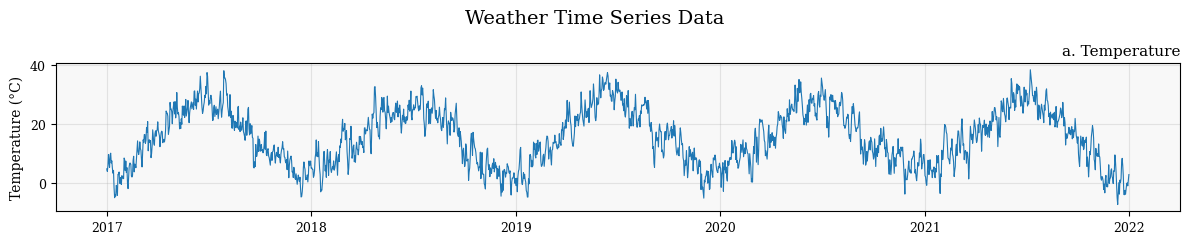

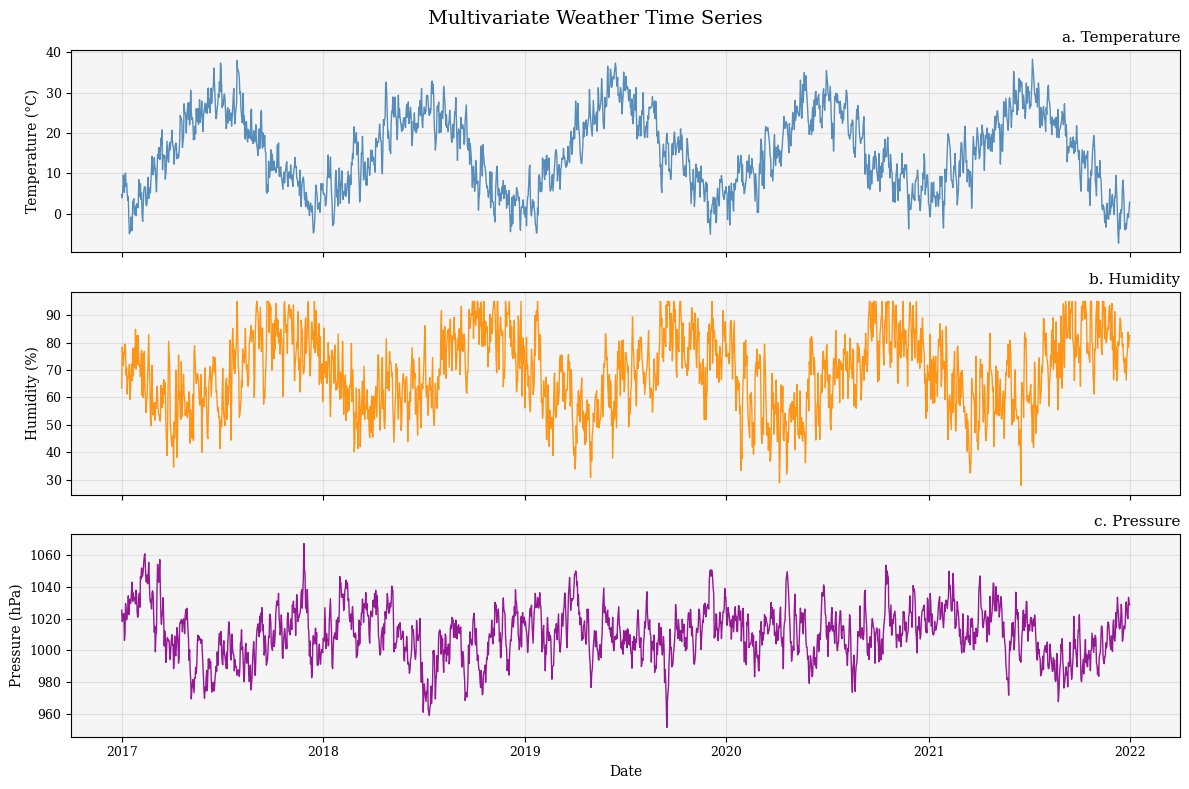

Weather Time Series Summary:
Date range: 2017-01-01 to 2021-12-31
Number of observations: 1826

Temperature Statistics:
  Mean: 15.43°C
  Std:  9.47°C
  Range: -7.3°C to 38.3°C

Humidity Statistics:
  Mean: 69.37%
  Std:  13.86%
  Range: 28.0% to 95.0%

Pressure Statistics:
  Mean: 1010.58 hPa
  Std:  16.45 hPa
  Range: 951.3 hPa to 1067.3 hPa

Files saved:
- three_weather_series.pgf
- multivariate_weather_timeseries.pgf (styled like your reference)
- PNG versions of both plots


: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# Set up matplotlib for publication-quality plots
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'serif',
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 12,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.axisbelow': True
})

# Generate realistic weather data
np.random.seed(42)
start_date = "2017-01-01"
end_date = "2021-12-31"
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
n_days = len(date_range)

def generate_weather_series(dates):
    """Generate three realistic weather time series"""
    n = len(dates)
    
    # Temperature series
    temperature = []
    for i, date in enumerate(dates):
        day_of_year = date.timetuple().tm_yday
        # Seasonal pattern
        temp_seasonal = 15 + 12 * np.sin(2 * np.pi * (day_of_year - 80) / 365)
        # Random variation
        temp_noise = np.random.normal(0, 3)
        # Persistence (weather patterns)
        if i > 0:
            temp_persistence = 0.7 * (temperature[-1] - temp_seasonal)
        else:
            temp_persistence = 0
        
        temp = temp_seasonal + temp_persistence + temp_noise
        temperature.append(temp)
    
    # Humidity series (somewhat inversely related to temperature)
    humidity = []
    for i, (date, temp) in enumerate(zip(dates, temperature)):
        day_of_year = date.timetuple().tm_yday
        # Base humidity inversely related to temperature
        hum_base = 70 - 1.0 * (temp - 15)
        # Seasonal component
        hum_seasonal = 15 * np.sin(2 * np.pi * (day_of_year - 150) / 365)
        # Random variation
        hum_noise = np.random.normal(0, 8)
        # Persistence
        if i > 0:
            hum_persistence = 0.6 * (humidity[-1] - hum_base - hum_seasonal)
        else:
            hum_persistence = 0
        
        hum = hum_base + hum_seasonal + hum_persistence + hum_noise
        hum = np.clip(hum, 15, 95)  # Keep realistic bounds
        humidity.append(hum)
    
    # Pressure series
    pressure = []
    for i, date in enumerate(dates):
        day_of_year = date.timetuple().tm_yday
        # Seasonal pattern (higher pressure in winter)
        press_seasonal = 1013 + 10 * np.cos(2 * np.pi * (day_of_year - 30) / 365)
        # Random variation (pressure systems)
        press_noise = np.random.normal(0, 8)
        # Persistence (pressure systems last days)
        if i > 0:
            press_persistence = 0.85 * (pressure[-1] - press_seasonal)
        else:
            press_persistence = 0
        
        press = press_seasonal + press_persistence + press_noise
        pressure.append(press)
    
    return np.array(temperature), np.array(humidity), np.array(pressure)

# Generate the three time series
temperature, humidity, pressure = generate_weather_series(date_range)

# Create DataFrame
df = pd.DataFrame({
    'date': date_range,
    'temperature': temperature,
    'humidity': humidity,
    'pressure': pressure
})

# Create the three-panel plot (similar to your reference image)
fig, axes = plt.subplots(1, 1, figsize=(12, 2), sharex=True)
fig.suptitle('Weather Time Series Data', fontsize=14, y=1.2)

# Panel a: Temperature
axes.plot(df['date'], df['temperature'], color='#1f77b4', linewidth=0.8)
axes.set_ylabel('Temperature (°C)')
axes.set_title('a. Temperature', loc='right', fontsize=11)
axes.grid(True, alpha=0.3)
axes.set_facecolor('#F8F8F8')

# Panel b: Humidity
# axes[1].plot(df['date'], df['humidity'], color='#ff7f0e', linewidth=0.8)
# axes[1].set_ylabel('Humidity (%)')
# axes[1].set_title('b. Humidity', loc='right', fontsize=11)
# axes[1].grid(True, alpha=0.3)
# axes[1].set_facecolor('#F8F8F8')

# # Panel c: Pressure
# axes[2].plot(df['date'], df['pressure'], color='#2ca02c', linewidth=0.8)
# axes[2].set_ylabel('Pressure (hPa)')
# axes[2].set_xlabel('Date')
# axes[2].set_title('c. Pressure', loc='right', fontsize=11)
# axes[2].grid(True, alpha=0.3)
# axes[2].set_facecolor('#F8F8F8')

# Format all axes
# for ax in axes:
axes.tick_params(axis='both', labelsize=9)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig("three_weather_series.pgf", bbox_inches='tight', dpi=300)
plt.savefig("three_weather_series.png", bbox_inches='tight', dpi=300)
plt.show()

# Alternative version with different colors matching your reference more closely
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Multivariate Weather Time Series', fontsize=14, y=0.98)

# Use colors similar to your reference image
colors = ['#4682B4', '#FF8C00', '#8B008B']  # Steel blue, orange, purple
series_names = ['Temperature', 'Humidity', 'Pressure']
series_data = [df['temperature'], df['humidity'], df['pressure']]
units = ['(°C)', '(%)', '(hPa)']

for i, (ax, color, name, data, unit) in enumerate(zip(axes, colors, series_names, series_data, units)):
    ax.plot(df['date'], data, color=color, linewidth=1.0, alpha=0.9)
    ax.set_ylabel(f'{name} {unit}')
    ax.set_title(f'{chr(97+i)}. {name}', loc='right', fontsize=11)
    # ax.grid(True, alpha=0.4, color='white', linewidth=0.8)
    ax.grid(True, alpha=0.3)
    
    ax.set_facecolor('#F5F5F5')  # Light gray background like your reference
    ax.tick_params(axis='both', labelsize=9)


axes[-1].set_xlabel('Date')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig("multivariate_weather_timeseries.pgf", bbox_inches='tight', dpi=300)
plt.savefig("multivariate_weather_timeseries.png", bbox_inches='tight', dpi=300)
plt.show()

# Print basic statistics
print("Weather Time Series Summary:")
print("=" * 40)
print(f"Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
print(f"Number of observations: {len(df)}")
print()
print("Temperature Statistics:")
print(f"  Mean: {df['temperature'].mean():.2f}°C")
print(f"  Std:  {df['temperature'].std():.2f}°C")
print(f"  Range: {df['temperature'].min():.1f}°C to {df['temperature'].max():.1f}°C")
print()
print("Humidity Statistics:")
print(f"  Mean: {df['humidity'].mean():.2f}%")
print(f"  Std:  {df['humidity'].std():.2f}%")
print(f"  Range: {df['humidity'].min():.1f}% to {df['humidity'].max():.1f}%")
print()
print("Pressure Statistics:")
print(f"  Mean: {df['pressure'].mean():.2f} hPa")
print(f"  Std:  {df['pressure'].std():.2f} hPa")
print(f"  Range: {df['pressure'].min():.1f} hPa to {df['pressure'].max():.1f} hPa")

print("\nFiles saved:")
print("- three_weather_series.pgf")
print("- multivariate_weather_timeseries.pgf (styled like your reference)")
print("- PNG versions of both plots")